In [1]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
warnings.filterwarnings("ignore")

In [2]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import numpy as np
import scanpy as sc
import vqtcr as vq

In [3]:
path_base = '/mnt/d/Dataset/vqTCR/10xGenomics/'
path_data = path_base + 'avidity_esm.h5ad'

In [4]:
vq.set_random_seed(2025)
adata = sc.read_h5ad(path_data)
adata = adata[adata.obs['binding_name'].isin(vq.HIGH_COUNT_ANTIGENS)]
adata

View of AnnData object with n_obs × n_vars = 61096 × 5000
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'barcode',

In [5]:
params = vq.get_pred_config(lr=1e-4, latent_dim=64, dropout=0.2)
params['epoch'] = 20
params['pred']['dim_latent'] = int(1.5*64)
params

{'dim_latent': 64,
 'batch_size': 512,
 'lr': 0.0001,
 'dropout': 0.2,
 'epoch': 20,
 'early': 10,
 'dataset': '',
 'save_path': '',
 'direction': 'max',
 'weight_decay': 0.0001,
 'loss_weight': [1.0, 1.0, 1.0, 1.0],
 'gex': {'dim_latent': 64, 'act': 'elu', 'norm': True},
 'tcr': {'esm_type': 'facebook/esm2_t6_8M_UR50D',
  'kmer_kernels': [1, 3, 5, 7],
  'dim_latent': 64,
  'dim_emb': 64,
  'num_heads': 8,
  'forward_expansion': 4,
  'dropout': 0.2,
  'num_encoder': 2,
  'num_decoder': 2,
  'mask_rate': 0.15,
  'beta_only': False,
  'esm_tokens': True},
 'fus': {'dim_latent': 64, 'dropout': 0.2, 'film_reg': 1.0},
 'pty': {'dim_latent': 128,
  'num_subspace': 3,
  'codewords_per_space': 64,
  'eps': 1e-05,
  'init_scale': 1.0,
  'ema_decay': 0.99,
  'commitment_beta': 0.25,
  'use_cosine': True,
  'dead_code_interval': 1000,
  'dead_code_threshold': 0.0001,
  'dead_code_topk': 16,
  'diversity_weight': 0.001},
 'pred': {'dim_latent': 96, 'dropout': 0.2, 'n_labels': 8}}

Leave one donor out(LoDonor) TCR-pMHC binding prediction

pretrain on all donors

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


warmup codebook:   0%|          | 0/20 [00:00<?, ?it/s]

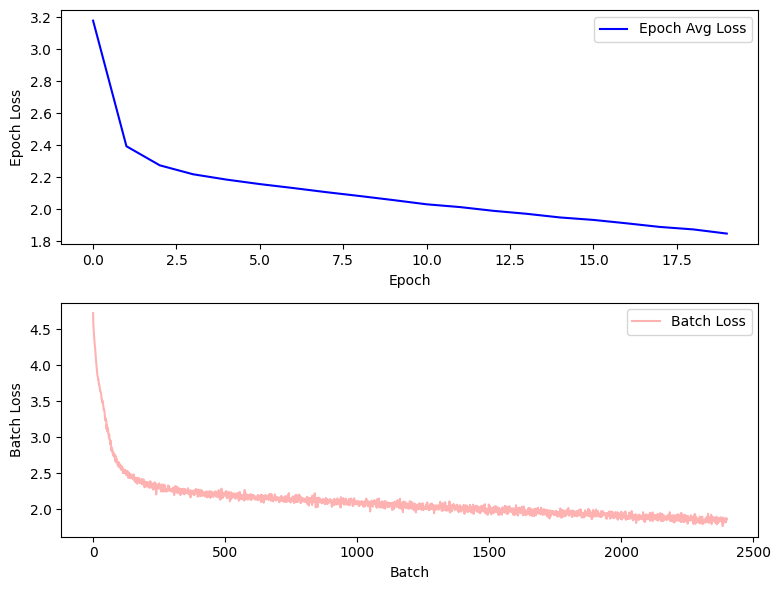

In [6]:
vqtcr = vq.vqTCR_Bench(params, adata, labels='binding_name', model='PoE')
vqtcr.pretrain(col_name='donor', 
               set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'],
               sample_mode='clonotype', 
               shuffle=False,
               labels=None,
               visual=True)

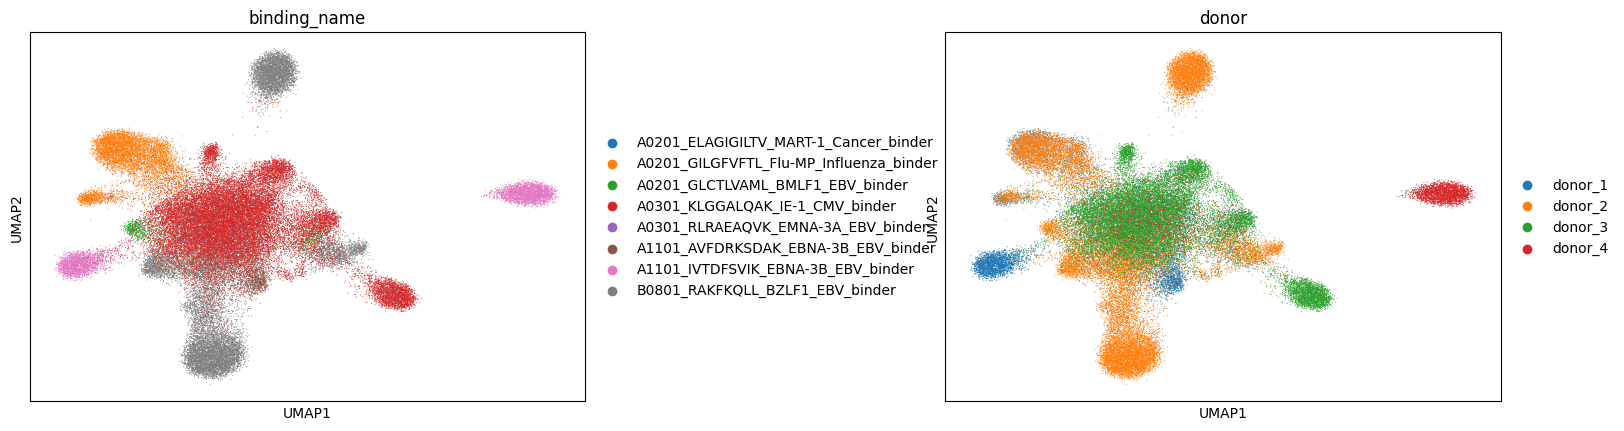

In [7]:
adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcell')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

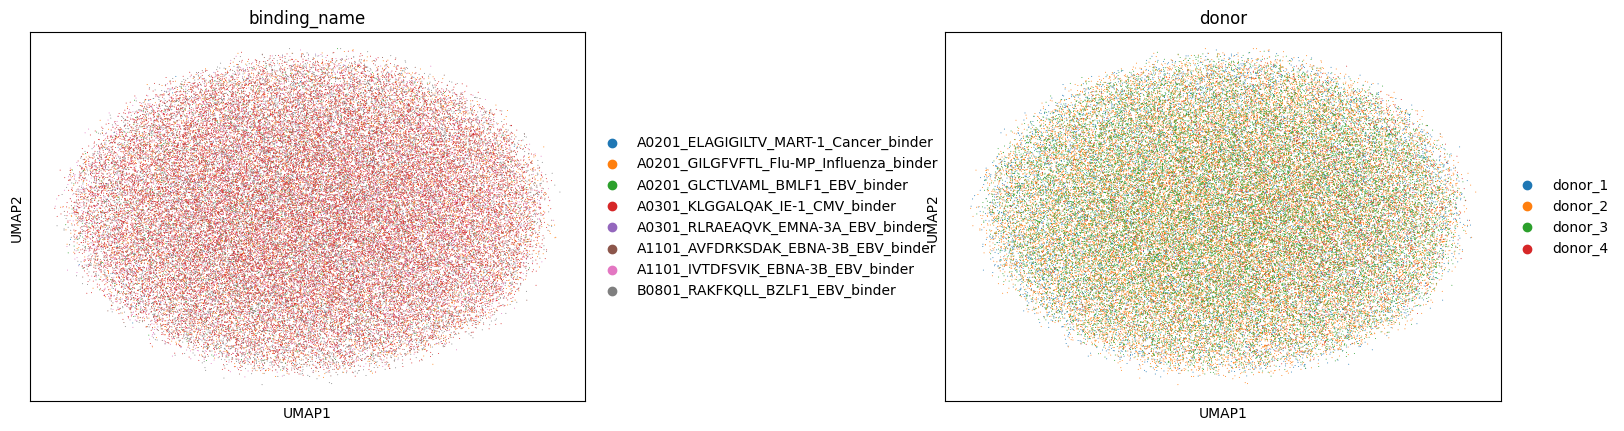

In [8]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcr')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

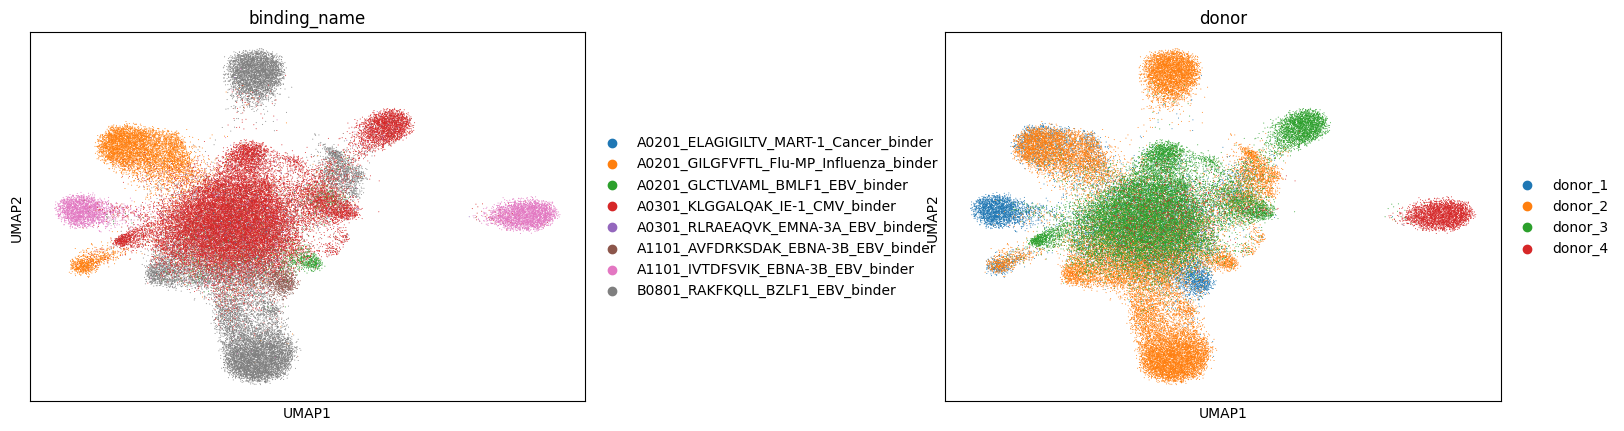

In [9]:
# gex residual latent space
sc.pp.neighbors(adata, use_rep='hgex')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['binding_name', 'donor'], wspace=0.5)

prediction training on remianing patients and test on leave-out patient

In [10]:
# test_score = vqtcr.compute_metrics(metrics='knn_prediction', eval_set='test')
record = {}
adata = vqtcr.get_latent(adata,col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
adata_train = adata[adata.obs['set'].isin(['train', 'valid'])]
adata_valid = adata[adata.obs['set']=='test']

knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                            adata_train.obs['binding_name'], 
                            adata_valid.obs['binding_name'])
record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
record['knn_prediction']

0.2831419977045445

In [11]:
adata = vq.split_adata(adata, split_col='clonotype', random_seed=2025)
record = {}
adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
adata_train = adata[adata.obs['set']=='train']
adata_valid = adata[adata.obs['set']=='test']

knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                            adata_train.obs['binding_name'], 
                            adata_valid.obs['binding_name'])
record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
record['knn_prediction']

0.3227566858343656

In [12]:
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut
logo = LeaveOneGroupOut()
all_test_metrics = []
donor_ids = adata.obs.donor.to_numpy()
import numpy as np
for train_valid_idx, test_idx in logo.split(X=adata.X, groups=donor_ids):
    test_donor = donor_ids[test_idx][0]
    print(f"\n=== test on {test_donor} ===")
    adata.obs.loc[adata.obs.index[train_valid_idx], 'set']='train'
    adata.obs.loc[adata.obs.index[test_idx], 'set'] = 'test'
    record = {}
    adata = vqtcr.get_latent(adata, col_name='donor', set_name=['donor_1', 'donor_2', 'donor_3', 'donor_4'])
    adata_train = adata[adata.obs['set']=='train']
    adata_valid = adata[adata.obs['set']=='test']

    knn_scores = vq.get_knn_cls(adata_train.obsm['htcr'], adata_valid.obsm['htcr'],
                                adata_train.obs['binding_name'], 
                                adata_valid.obs['binding_name'])
    record['knn_prediction'] = knn_scores['weighted avg']['f1-score']
    print(record['knn_prediction'])


=== test on donor_1 ===
0.13439406560342465

=== test on donor_2 ===
0.034906404489219854

=== test on donor_3 ===
0.23887722439143638

=== test on donor_4 ===
0.08740815262150244


In [13]:
all_test_metrics = []
for train_valid_idx, test_idx in logo.split(X=adata.X, groups=donor_ids):
    test_donor = donor_ids[test_idx][0]
    print(f"\n=== test on {test_donor} ===")
    # split train-valid dataset
    adata_train_val = adata[train_valid_idx]
    train, val = vq.split_dataset(adata_train_val, split_ratio=0.25, 
                                  split_col='clonotype', random_seed=2025)
    adata.obs['set'] = None
    adata.obs.loc[train.obs.index, 'set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'valid'
    adata.obs.loc[adata.obs.index[test_idx], 'set'] = 'test'
    trainloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['train'],
                                     sample_mode='clonotype',
                                     shuffle=False, 
                                     labels='binding_name')
    validloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['valid'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    testloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['test'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    best_score = vqtcr.predict_train(trainloader, validloader)
    print(f'best score in validation: {best_score}')
    
    test_metrics = vqtcr.predict_test(testloader)
    all_test_metrics.append(test_metrics)
    
metric = 'weighted'
print("\n" + "="*60)
print("LOGO交叉验证最终结果:")
for i, metrics in enumerate(all_test_metrics):
        print(f"病人 {np.unique(donor_ids)[i]}: "
              f"f1: {metrics[f'f1_{metric}']:.3f}, "
              f"AUC-ROC: {metrics[f'auc_roc_{metric}']:.3f}, "
              f"AUC-PR: {metrics[f'auc_pr_{metric}']:.3f}")
    
# 计算平均性能
mean_f1 = np.nanmean([m[f'f1_{metric}'] for m in all_test_metrics])
mean_auc_roc = np.nanmean([m[f'auc_roc_{metric}'] for m in all_test_metrics])
mean_auc_pr = np.nanmean([m[f'auc_pr_{metric}'] for m in all_test_metrics])

print(f"\n平均性能: "
        f"fa: {mean_f1:.3f} ± {np.nanstd([m[f'f1_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-ROC: {mean_auc_roc:.3f} ± {np.nanstd([m[f'auc_roc_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-PR: {mean_auc_pr:.3f} ± {np.nanstd([m[f'auc_pr_{metric}'] for m in all_test_metrics]):.3f}")


=== test on donor_1 ===


Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.547
Val F1: 0.643, Val AUC-ROC: 0.858, Val AUC-PR: 0.318
Epoch 2/20:
  Train Loss: 1.264
Val F1: 0.766, Val AUC-ROC: 0.924, Val AUC-PR: 0.375
Epoch 3/20:
  Train Loss: 0.996
Val F1: 0.804, Val AUC-ROC: 0.939, Val AUC-PR: 0.389
Epoch 4/20:
  Train Loss: 0.851
Val F1: 0.805, Val AUC-ROC: 0.942, Val AUC-PR: 0.394
Epoch 5/20:
  Train Loss: 0.734
Val F1: 0.805, Val AUC-ROC: 0.947, Val AUC-PR: 0.405
Epoch 6/20:
  Train Loss: 0.754
Val F1: 0.793, Val AUC-ROC: 0.948, Val AUC-PR: 0.405
Epoch 7/20:
  Train Loss: 0.717
Val F1: 0.798, Val AUC-ROC: 0.952, Val AUC-PR: 0.411
Epoch 8/20:
  Train Loss: 0.667
Val F1: 0.793, Val AUC-ROC: 0.953, Val AUC-PR: 0.410
Epoch 9/20:
  Train Loss: 0.397
Val F1: 0.795, Val AUC-ROC: 0.954, Val AUC-PR: 0.417
Epoch 10/20:
  Train Loss: 0.502
Val F1: 0.798, Val AUC-ROC: 0.956, Val AUC-PR: 0.410
Epoch 11/20:
  Train Loss: 0.641
Val F1: 0.805, Val AUC-ROC: 0.958, Val AUC-PR: 0.415
Epoch 12/20:
  Train Loss: 0.458
Val F1: 0.800, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.872
Val F1: 0.425, Val AUC-ROC: 0.615, Val AUC-PR: 0.257
Epoch 2/20:
  Train Loss: 1.577
Val F1: 0.560, Val AUC-ROC: 0.703, Val AUC-PR: 0.314
Epoch 3/20:
  Train Loss: 1.320
Val F1: 0.604, Val AUC-ROC: 0.753, Val AUC-PR: 0.337
Epoch 4/20:
  Train Loss: 1.135
Val F1: 0.644, Val AUC-ROC: 0.804, Val AUC-PR: 0.361
Epoch 5/20:
  Train Loss: 0.977
Val F1: 0.548, Val AUC-ROC: 0.791, Val AUC-PR: 0.364
Epoch 6/20:
  Train Loss: 0.832
Val F1: 0.559, Val AUC-ROC: 0.821, Val AUC-PR: 0.379
Epoch 7/20:
  Train Loss: 0.778
Val F1: 0.460, Val AUC-ROC: 0.792, Val AUC-PR: 0.368
Epoch 8/20:
  Train Loss: 0.711
Val F1: 0.512, Val AUC-ROC: 0.829, Val AUC-PR: 0.378
Epoch 9/20:
  Train Loss: 0.658
Val F1: 0.470, Val AUC-ROC: 0.823, Val AUC-PR: 0.372
Epoch 10/20:
  Train Loss: 0.651
Val F1: 0.533, Val AUC-ROC: 0.847, Val AUC-PR: 0.375
Epoch 11/20:
  Train Loss: 0.611
Val F1: 0.560, Val AUC-ROC: 0.861, Val AUC-PR: 0.384
Epoch 12/20:
  Train Loss: 0.627
Val F1: 0.551, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.656
Val F1: 0.495, Val AUC-ROC: 0.812, Val AUC-PR: 0.302
Epoch 2/20:
  Train Loss: 1.427
Val F1: 0.661, Val AUC-ROC: 0.893, Val AUC-PR: 0.390
Epoch 3/20:
  Train Loss: 1.270
Val F1: 0.716, Val AUC-ROC: 0.918, Val AUC-PR: 0.421
Epoch 4/20:
  Train Loss: 1.168
Val F1: 0.745, Val AUC-ROC: 0.930, Val AUC-PR: 0.440
Epoch 5/20:
  Train Loss: 1.102
Val F1: 0.760, Val AUC-ROC: 0.939, Val AUC-PR: 0.454
Epoch 6/20:
  Train Loss: 0.992
Val F1: 0.766, Val AUC-ROC: 0.943, Val AUC-PR: 0.456
Epoch 7/20:
  Train Loss: 1.031
Val F1: 0.771, Val AUC-ROC: 0.948, Val AUC-PR: 0.464
Epoch 8/20:
  Train Loss: 0.866
Val F1: 0.785, Val AUC-ROC: 0.952, Val AUC-PR: 0.483
Epoch 9/20:
  Train Loss: 0.997
Val F1: 0.781, Val AUC-ROC: 0.954, Val AUC-PR: 0.466
Epoch 10/20:
  Train Loss: 0.977
Val F1: 0.784, Val AUC-ROC: 0.955, Val AUC-PR: 0.482
Epoch 11/20:
  Train Loss: 0.994
Val F1: 0.778, Val AUC-ROC: 0.955, Val AUC-PR: 0.490
Epoch 12/20:
  Train Loss: 0.905
Val F1: 0.783, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.328
Val F1: 0.692, Val AUC-ROC: 0.882, Val AUC-PR: 0.333
Epoch 2/20:
  Train Loss: 1.747
Val F1: 0.743, Val AUC-ROC: 0.913, Val AUC-PR: 0.368
Epoch 3/20:
  Train Loss: 1.149
Val F1: 0.744, Val AUC-ROC: 0.918, Val AUC-PR: 0.382
Epoch 4/20:
  Train Loss: 0.514
Val F1: 0.693, Val AUC-ROC: 0.917, Val AUC-PR: 0.387
Epoch 5/20:
  Train Loss: 1.630
Val F1: 0.723, Val AUC-ROC: 0.925, Val AUC-PR: 0.394
Epoch 6/20:
  Train Loss: 1.588
Val F1: 0.646, Val AUC-ROC: 0.923, Val AUC-PR: 0.399
Epoch 7/20:
  Train Loss: 0.339
Val F1: 0.709, Val AUC-ROC: 0.929, Val AUC-PR: 0.397
Epoch 8/20:
  Train Loss: 0.234
Val F1: 0.718, Val AUC-ROC: 0.930, Val AUC-PR: 0.396
Epoch 9/20:
  Train Loss: 1.515
Val F1: 0.714, Val AUC-ROC: 0.932, Val AUC-PR: 0.407
Epoch 10/20:
  Train Loss: 0.193
Val F1: 0.717, Val AUC-ROC: 0.933, Val AUC-PR: 0.409
Epoch 11/20:
  Train Loss: 0.657
Val F1: 0.715, Val AUC-ROC: 0.934, Val AUC-PR: 0.414
Epoch 12/20:
  Train Loss: 1.576
Val F1: 0.676, Val AUC-ROC: 0.

In [14]:
all_test_metrics = []
for i in range(5):
    adata = vq.split_adata(adata, split_col='clonotype', random_seed=i)
    trainloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['train'],
                                     sample_mode='clonotype',
                                     shuffle=False, 
                                     labels='binding_name')
    validloader = vq.get_dataloader(adata=adata, 
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['valid'],
                                     sample_mode=None,
                                     shuffle=False, 
                                     labels='binding_name')
    testloader = vq.get_dataloader(adata=adata,
                                     batch_size=params['batch_size'],
                                     col_name='set',
                                     set_name=['test'],
                                     sample_mode=None,
                                     shuffle=False,
                                     labels='binding_name')
    best_score = vqtcr.predict_train(trainloader, validloader)
    print(f'best score in validation: {best_score}')
    
    test_metrics = vqtcr.predict_test(testloader)
    all_test_metrics.append(test_metrics)

print("\n" + "="*60)
print("LOGO交叉验证最终结果:")
for i, metrics in enumerate(all_test_metrics):
        print(f"splite {i}: "
              f"F1: {metrics[f'f1_{metric}']:.3f}, "
              f"AUC-ROC: {metrics[f'auc_roc_{metric}']:.3f}, "
              f"AUC-PR: {metrics[f'auc_pr_{metric}']:.3f}")
    
# 计算平均性能
mean_f1 = np.nanmean([m[f'f1_{metric}'] for m in all_test_metrics])
mean_auc_roc = np.nanmean([m[f'auc_roc_{metric}'] for m in all_test_metrics])
mean_auc_pr = np.nanmean([m[f'auc_pr_{metric}'] for m in all_test_metrics])

print(f"\n平均性能: "
        f"F1: {mean_f1:.3f} ± {np.nanstd([m[f'f1_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-ROC: {mean_auc_roc:.3f} ± {np.nanstd([m[f'auc_roc_{metric}'] for m in all_test_metrics]):.3f}, "
        f"AUC-PR: {mean_auc_pr:.3f} ± {np.nanstd([m[f'auc_pr_{metric}'] for m in all_test_metrics]):.3f}")

    

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.633
Val F1: 0.645, Val AUC-ROC: 0.827, Val AUC-PR: 0.310
Epoch 2/20:
  Train Loss: 1.295
Val F1: 0.711, Val AUC-ROC: 0.853, Val AUC-PR: 0.341
Epoch 3/20:
  Train Loss: 1.103
Val F1: 0.741, Val AUC-ROC: 0.870, Val AUC-PR: 0.356
Epoch 4/20:
  Train Loss: 0.972
Val F1: 0.757, Val AUC-ROC: 0.877, Val AUC-PR: 0.369
Epoch 5/20:
  Train Loss: 0.870
Val F1: 0.759, Val AUC-ROC: 0.882, Val AUC-PR: 0.376
Epoch 6/20:
  Train Loss: 0.784
Val F1: 0.759, Val AUC-ROC: 0.882, Val AUC-PR: 0.376
Epoch 7/20:
  Train Loss: 0.758
Val F1: 0.761, Val AUC-ROC: 0.882, Val AUC-PR: 0.390
Epoch 8/20:
  Train Loss: 0.689
Val F1: 0.760, Val AUC-ROC: 0.888, Val AUC-PR: 0.384
Epoch 9/20:
  Train Loss: 0.766
Val F1: 0.761, Val AUC-ROC: 0.887, Val AUC-PR: 0.389
Epoch 10/20:
  Train Loss: 0.757
Val F1: 0.758, Val AUC-ROC: 0.883, Val AUC-PR: 0.384
Epoch 11/20:
  Train Loss: 0.588
Val F1: 0.760, Val AUC-ROC: 0.887, Val AUC-PR: 0.389
Epoch 12/20:
  Train Loss: 0.670
Val F1: 0.757, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.628
Val F1: 0.527, Val AUC-ROC: 0.744, Val AUC-PR: 0.292
Epoch 2/20:
  Train Loss: 1.275
Val F1: 0.620, Val AUC-ROC: 0.783, Val AUC-PR: 0.334
Epoch 3/20:
  Train Loss: 0.992
Val F1: 0.652, Val AUC-ROC: 0.798, Val AUC-PR: 0.345
Epoch 4/20:
  Train Loss: 0.909
Val F1: 0.661, Val AUC-ROC: 0.809, Val AUC-PR: 0.352
Epoch 5/20:
  Train Loss: 0.819
Val F1: 0.660, Val AUC-ROC: 0.816, Val AUC-PR: 0.357
Epoch 6/20:
  Train Loss: 0.778
Val F1: 0.659, Val AUC-ROC: 0.818, Val AUC-PR: 0.359
Epoch 7/20:
  Train Loss: 0.699
Val F1: 0.658, Val AUC-ROC: 0.817, Val AUC-PR: 0.362
Epoch 8/20:
  Train Loss: 0.713
Val F1: 0.655, Val AUC-ROC: 0.821, Val AUC-PR: 0.363
Epoch 9/20:
  Train Loss: 0.675
Val F1: 0.658, Val AUC-ROC: 0.825, Val AUC-PR: 0.371
Epoch 10/20:
  Train Loss: 0.677
Val F1: 0.659, Val AUC-ROC: 0.828, Val AUC-PR: 0.369
Epoch 11/20:
  Train Loss: 0.736
Val F1: 0.659, Val AUC-ROC: 0.830, Val AUC-PR: 0.377
Epoch 12/20:
  Train Loss: 0.662
Val F1: 0.662, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.708
Val F1: 0.696, Val AUC-ROC: 0.856, Val AUC-PR: 0.318
Epoch 2/20:
  Train Loss: 1.368
Val F1: 0.782, Val AUC-ROC: 0.917, Val AUC-PR: 0.361
Epoch 3/20:
  Train Loss: 1.168
Val F1: 0.807, Val AUC-ROC: 0.931, Val AUC-PR: 0.379
Epoch 4/20:
  Train Loss: 1.011
Val F1: 0.816, Val AUC-ROC: 0.941, Val AUC-PR: 0.384
Epoch 5/20:
  Train Loss: 0.835
Val F1: 0.822, Val AUC-ROC: 0.948, Val AUC-PR: 0.389
Epoch 6/20:
  Train Loss: 0.829
Val F1: 0.821, Val AUC-ROC: 0.950, Val AUC-PR: 0.401
Epoch 7/20:
  Train Loss: 0.711
Val F1: 0.818, Val AUC-ROC: 0.952, Val AUC-PR: 0.389
Epoch 8/20:
  Train Loss: 0.702
Val F1: 0.815, Val AUC-ROC: 0.953, Val AUC-PR: 0.402
Epoch 9/20:
  Train Loss: 0.776
Val F1: 0.817, Val AUC-ROC: 0.953, Val AUC-PR: 0.404
Epoch 10/20:
  Train Loss: 0.730
Val F1: 0.813, Val AUC-ROC: 0.954, Val AUC-PR: 0.399
Epoch 11/20:
  Train Loss: 0.694
Val F1: 0.818, Val AUC-ROC: 0.955, Val AUC-PR: 0.401
Epoch 12/20:
  Train Loss: 0.692
Val F1: 0.818, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.607
Val F1: 0.636, Val AUC-ROC: 0.830, Val AUC-PR: 0.317
Epoch 2/20:
  Train Loss: 1.259
Val F1: 0.702, Val AUC-ROC: 0.889, Val AUC-PR: 0.355
Epoch 3/20:
  Train Loss: 1.099
Val F1: 0.710, Val AUC-ROC: 0.908, Val AUC-PR: 0.374
Epoch 4/20:
  Train Loss: 0.993
Val F1: 0.703, Val AUC-ROC: 0.915, Val AUC-PR: 0.391
Epoch 5/20:
  Train Loss: 0.843
Val F1: 0.668, Val AUC-ROC: 0.914, Val AUC-PR: 0.399
Epoch 6/20:
  Train Loss: 0.765
Val F1: 0.664, Val AUC-ROC: 0.918, Val AUC-PR: 0.398
Epoch 7/20:
  Train Loss: 0.720
Val F1: 0.676, Val AUC-ROC: 0.923, Val AUC-PR: 0.413
Epoch 8/20:
  Train Loss: 0.727
Val F1: 0.698, Val AUC-ROC: 0.927, Val AUC-PR: 0.403
Epoch 9/20:
  Train Loss: 0.680
Val F1: 0.681, Val AUC-ROC: 0.928, Val AUC-PR: 0.418
Epoch 10/20:
  Train Loss: 0.714
Val F1: 0.677, Val AUC-ROC: 0.926, Val AUC-PR: 0.399
Epoch 11/20:
  Train Loss: 0.734
Val F1: 0.685, Val AUC-ROC: 0.929, Val AUC-PR: 0.405
Epoch 12/20:
  Train Loss: 0.693
Val F1: 0.687, Val AUC-ROC: 0.

Training prediction head:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:
  Train Loss: 1.669
Val F1: 0.652, Val AUC-ROC: 0.842, Val AUC-PR: 0.320
Epoch 2/20:
  Train Loss: 1.305
Val F1: 0.741, Val AUC-ROC: 0.917, Val AUC-PR: 0.375
Epoch 3/20:
  Train Loss: 1.111
Val F1: 0.765, Val AUC-ROC: 0.931, Val AUC-PR: 0.394
Epoch 4/20:
  Train Loss: 0.944
Val F1: 0.775, Val AUC-ROC: 0.935, Val AUC-PR: 0.406
Epoch 5/20:
  Train Loss: 0.829
Val F1: 0.779, Val AUC-ROC: 0.942, Val AUC-PR: 0.414
Epoch 6/20:
  Train Loss: 0.760
Val F1: 0.782, Val AUC-ROC: 0.947, Val AUC-PR: 0.417
Epoch 7/20:
  Train Loss: 0.802
Val F1: 0.776, Val AUC-ROC: 0.946, Val AUC-PR: 0.415
Epoch 8/20:
  Train Loss: 0.785
Val F1: 0.786, Val AUC-ROC: 0.947, Val AUC-PR: 0.418
Epoch 9/20:
  Train Loss: 0.679
Val F1: 0.784, Val AUC-ROC: 0.947, Val AUC-PR: 0.421
Epoch 10/20:
  Train Loss: 0.722
Val F1: 0.786, Val AUC-ROC: 0.950, Val AUC-PR: 0.430
Epoch 11/20:
  Train Loss: 0.685
Val F1: 0.786, Val AUC-ROC: 0.951, Val AUC-PR: 0.417
Epoch 12/20:
  Train Loss: 0.644
Val F1: 0.786, Val AUC-ROC: 0.